**IMPORTING DEPENDENCIES**

In [1]:
!pip install ipywidgets rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=d7dfa6840f8cf748662666a7dee482a810f329b1e31d8b828655d1093e0d7aa3
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import f1_score
import nltk
from multiprocessing import Pool, cpu_count
import numpy as np
import re

nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**IMPORTING DATASET**

In [3]:
import pandas as pd
# Loading the dataset
df = pd.read_json("hf://datasets/toughdata/quora-question-answer-dataset/Quora-QuAD.jsonl", lines=True)

df.head()

,question,answer
0,Why whenever I get in the shower my girlfriend...,Isn’t it awful? You would swear that there was...
1,"What is a proxy, and how can I use one?",A proxy server is a system or router that prov...
2,"What song has the lyrics ""someone left the cak...",MacArthur's Park\n
3,I am the owner of an adult website called http...,Don't let apps that are liers put adds on your...
4,Does the Bible mention anything about a place ...,St. John in the book of Revelation mentions an...


**ROUTINE PREPROCESSING**

In [4]:
# Information about the dataset
df.info()

# Data cleaning
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

df['question'] = df['question'].apply(clean_text)
df['answer'] = df['answer'].apply(clean_text)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56402 entries, 0 to 56401
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  56402 non-null  object
 1   answer    56402 non-null  object
dtypes: object(2)
memory usage: 881.4+ KB


In [5]:
# Tokenization, stop word removal, and stemming
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]  # Removing stop words
    tokens = [stemmer.stem(word) for word in tokens]  # Applying stemming
    return ' '.join(tokens)

df['question'] = df['question'].apply(preprocess_text)
df['answer'] = df['answer'].apply(preprocess_text)

In [6]:
df.head()

,question,answer
0,whenev get shower girlfriend want join,isnt aw would swear wasnt enough hot water go ...
1,proxi use one,proxi server system router provid gateway user...
2,song lyric someon left cake rain,macarthur park
3,owner adult websit call httpsmatureanalloversc...,dont let app lier put add site like one say fr...
4,bibl mention anyth place heaven hell,st john book revel mention address scholar sug...


**USING PRETRAINED MODELS**

In [7]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline
# Defining model names
models = {
    'bert': 'google-bert/bert-large-uncased-whole-word-masking-finetuned-squad',
    'flan_t5': 'sjrhuschlee/flan-t5-base-squad2',
    'gpt2': 'anas-awadalla/gpt2-span-head-few-shot-k-16-finetuned-squad-seed-0'
}

# Initializing models and tokenizers
pipelines = {}
for name, model_name in models.items():
    model = AutoModelForQuestionAnswering.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    qa_pipeline = pipeline('question-answering', model=model, tokenizer=tokenizer, device = 0)
    pipelines[name] = qa_pipeline

2024-07-29 11:29:29.126310: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 11:29:29.126418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 11:29:29.253877: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.23k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/921 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

**EVALUATION**

In [8]:
# Function to get answers with error handling
def get_answer(row, model_name):
    question = row['question']
    context = row['answer']

    # Checking if question or context is empty
    if not question or not context:
        return "No answer available"

    qa = pipelines[model_name]
    result = qa(question=question, context=context)
    return result['answer']

# Function to calculate metrics
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def calculate_metrics(reference, predicted):
    # Calculate ROUGE score
    rouge_scores = scorer.score(reference, predicted)

    # Calculating BLEU score
    reference_tokens = nltk.word_tokenize(reference)
    predicted_tokens = nltk.word_tokenize(predicted)
    bleu_score = sentence_bleu([reference_tokens], predicted_tokens)

    # Calculating F1 score
    reference_tokens_set = set(reference_tokens)
    predicted_tokens_set = set(predicted_tokens)

    if not reference_tokens_set:  
        precision = recall = f1 = 0
    else:
        common_tokens = reference_tokens_set & predicted_tokens_set
        precision = len(common_tokens) / len(predicted_tokens_set) if predicted_tokens_set else 0
        recall = len(common_tokens) / len(reference_tokens_set)
        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)

    return {
        'rouge1': rouge_scores['rouge1'].fmeasure,
        'rouge2': rouge_scores['rouge2'].fmeasure,
        'rougeL': rouge_scores['rougeL'].fmeasure,
        'bleu': bleu_score,
        'f1': f1
    }

In [9]:
# Generating answers for each model
for model_name in models.keys():
    df[f'predicted_answer_{model_name}'] = df.apply(lambda row: get_answer(row, model_name), axis=1)

# Applying evaluation
all_metrics = {}
for model_name in models.keys():
    metrics = df.apply(lambda x: calculate_metrics(x['answer'], x[f'predicted_answer_{model_name}']), axis=1)
    metrics_df = pd.DataFrame(metrics.tolist())
    average_scores = metrics_df.mean()
    all_metrics[model_name] = average_scores

# Average scores for each model
for model_name, scores in all_metrics.items():
    print(f"Model: {model_name}")
    print("Average ROUGE-1 Score:", scores['rouge1'])
    print("Average ROUGE-2 Score:", scores['rouge2'])
    print("Average ROUGE-L Score:", scores['rougeL'])
    print("Average BLEU Score:", scores['bleu'])
    print("Average F1 Score:", scores['f1'])
    print("")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Model: bert
Average ROUGE-1 Score: 0.29275887427351016
Average ROUGE-2 Score: 0.22658508279133857
Average ROUGE-L Score: 0.29275887427351016
Average BLEU Score: 0.15501534531770816
Average F1 Score: 0.3131977970899778

Model: flan_t5
Average ROUGE-1 Score: 0.2664656218095823
Average ROUGE-2 Score: 0.19582659978780728
Average ROUGE-L Score: 0.26646535439076274
Average BLEU Score: 0.1346996297472278
Average F1 Score: 0.2849548102818311

Model: gpt2
Average ROUGE-1 Score: 0.2367169576991198
Average ROUGE-2 Score: 0.13765840923439
Average ROUGE-L Score: 0.2367169576991198
Average BLEU Score: 0.0777791024144392
Average F1 Score: 0.25391952899405495



**DATA VISUALIZATION**

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for better-looking plots
plt.style.use('seaborn')

/tmp/ipykernel_34/3485417478.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/si

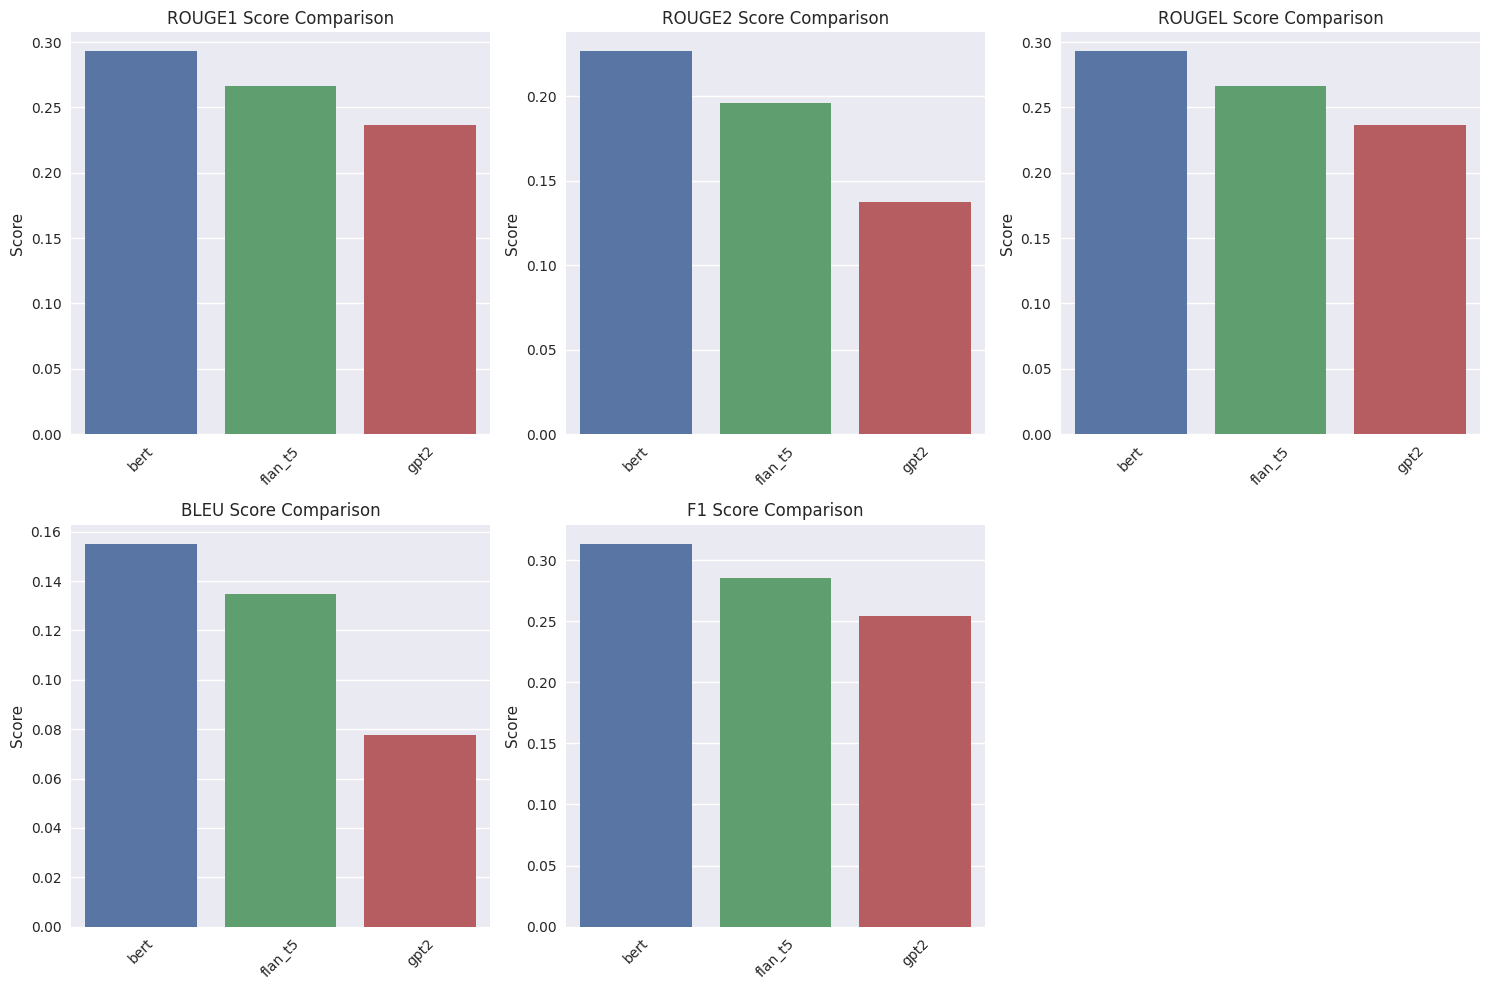

In [11]:
#Model Performance Comparison
model_names = list(all_metrics.keys())
metrics = ['rouge1', 'rouge2', 'rougeL', 'bleu', 'f1']

plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    values = [all_metrics[model][metric] for model in model_names]
    sns.barplot(x=model_names, y=values)
    plt.title(f'{metric.upper()} Score Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

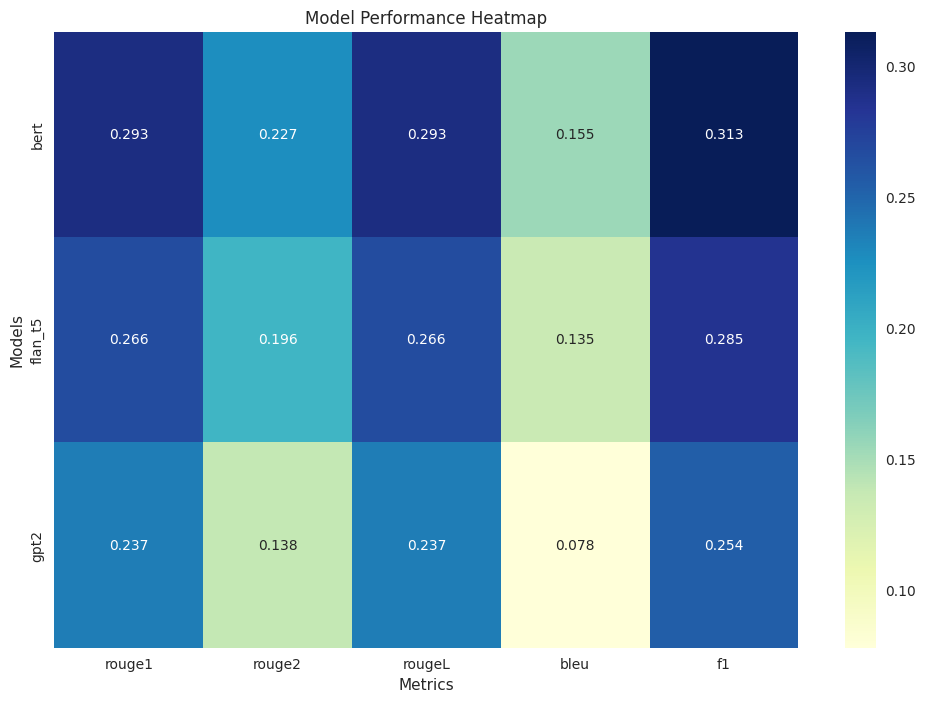

In [12]:
#Heatmap of Model Performance
heatmap_data = pd.DataFrame(all_metrics).T

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Model Performance Heatmap')
plt.ylabel('Models')
plt.xlabel('Metrics')
plt.show()

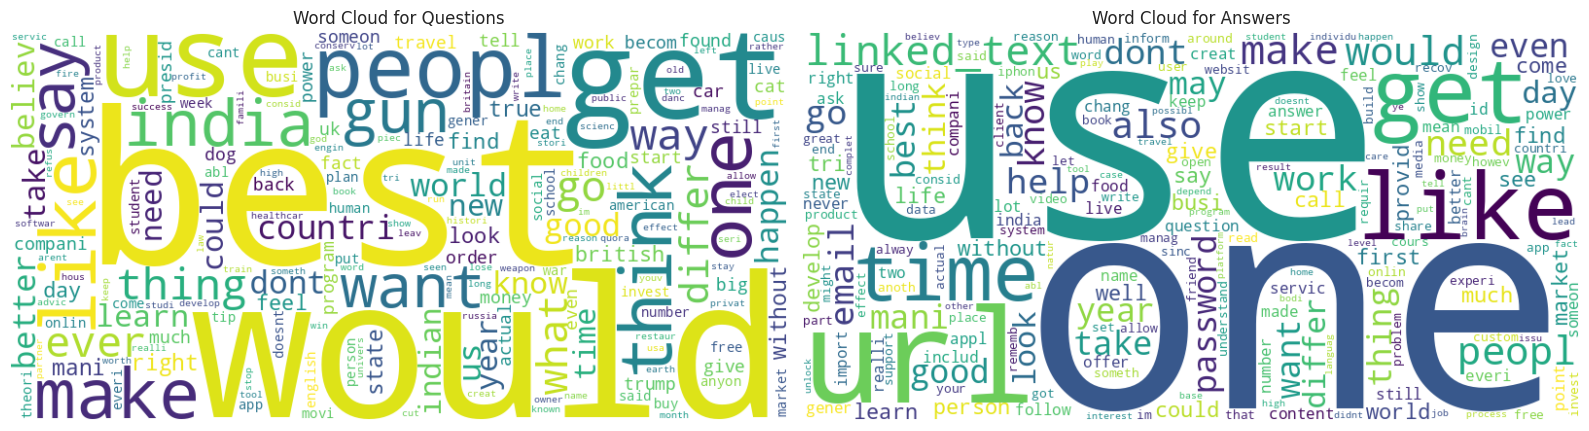

In [13]:
#Feature Importance
from collections import Counter
from wordcloud import WordCloud

# Combining all questions and answers into one string
all_questions = ' '.join(df['question'])
all_answers = ' '.join(df['answer'])

# Generating word frequencies
question_word_freq = Counter(all_questions.split())
answer_word_freq = Counter(all_answers.split())

# Generating word clouds
question_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(question_word_freq)
answer_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(answer_word_freq)

# Plotting the word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(question_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Questions')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(answer_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Answers')
plt.axis('off')

plt.tight_layout()
plt.show()


In [15]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [16]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Initializing the BERT model and tokenizer
model_name = 'google-bert/bert-large-uncased-whole-word-masking-finetuned-squad'
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
qa_pipeline = pipeline('question-answering', model=model, tokenizer=tokenizer, device=0)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Some weights of the model checkpoint at google-bert/bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
def answer_question(question, context):
    result = qa_pipeline(question=question, context=context)
    return result['answer']

def extract_keywords(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    keywords = [word for word in tokens if word not in stop_words and word.isalnum()]
    return keywords

def find_context_for_question(question, df):
    keywords = extract_keywords(question)
    best_match = None
    max_overlap = 0

    for index, row in df.iterrows():
        question_keywords = extract_keywords(row['question'])
        overlap = len(set(keywords) & set(question_keywords))
        if overlap > max_overlap:
            max_overlap = overlap
            best_match = row['answer']

    return best_match if best_match else "Context not found in the dataset."

In [18]:
# Asking the user for a question
user_question = input("Please enter your question: ")

# Finding the most relevant context from the dataset
context = find_context_for_question(user_question, df)

if context != "Context not found in the dataset.":
    # Getting the answer from the model
    answer = answer_question(user_question, context)
    print(f"Answer: {answer}")
else:
    print("Sorry, the context for your question was not found in the dataset.")

Please enter your question:  What is a proxy, and how can I use one?


Answer: proxi server
